In [25]:
!nvidia-smi

Tue Jan  7 13:54:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1070      WDDM  |   00000000:01:00.0 Off |                  N/A |
| 35%   29C    P8             12W /  230W |      89MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from numba import cuda
import numpy as np
import time

In [26]:
# Обычное суммирование по одному элементу - последовательное вычисление суммы
def sum_cpu(vector):
    start_time = time.time()
    result = 0.0
    for element in vector:
        result += element
    end_time = time.time()
    return result, end_time - start_time

In [57]:
@cuda.jit
def sum_kernel(data_vector, results):

    # Создание общей памяти для 140 потоков
    shared_memory = cuda.shared.array(140, dtype=np.float64)

    thread_id = cuda.threadIdx.x
    global_index = cuda.grid(1)

    # Каждый поток загружает соответствующий элемент в общую память, если индекс в пределах вектора (для редукции последующей)
    if global_index < data_vector.size:
        shared_memory[thread_id] = data_vector[global_index]
    else:
        shared_memory[thread_id] = 0.0  # В противном случае присваиваем 0

    # # Не уверен в необходимости, но 
    # cuda.syncthreads синхронизирует все потоки в блоке, чтобы убедиться, что все данные загружены в общую память перед началом редукции
    cuda.syncthreads()

    # Сама редукция, которая продолжается, пока не получу одну сумму частичную
    stride = cuda.blockDim.x // 2
    while stride > 0:
        if thread_id < stride:
            shared_memory[thread_id] += shared_memory[thread_id + stride]
        cuda.syncthreads()  
        stride //= 2

    # Запись результата в массив частичных сумм
    if thread_id == 0:
        results[cuda.blockIdx.x] = shared_memory[0]

In [58]:
def sum_gpu(vector):
    start_time = time.time()

    d_vector = cuda.to_device(vector)

    blocks_per_grid = (vector.size + 139) // 140

    # Определяется кол-во результирующих сумм (частичных сумм) для текущего вектора, который получаю из списка в функции run_experiments()
    d_partial_sums = cuda.device_array((blocks_per_grid,), dtype=np.float64)

    threads_per_block = 140
    sum_kernel[blocks_per_grid, threads_per_block](d_vector, d_partial_sums)

    # Копируем частичные суммы обратно на CPU и суммируем их
    partial_sums = d_partial_sums.copy_to_host()
    result = np.sum(partial_sums)

    end_time = time.time()
    return result, end_time - start_time

In [59]:
import matplotlib.pyplot as plt
import pandas as pd
from numba import NumbaPerformanceWarning
import warnings
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

# Представление результата в таком удобном формате подсмотрел у других студентов
def run_experiments():
    sizes = [10000, 40000, 1000000, 5000000, 10000000] # Не стал брать 1000 элементов, чтобы график был более показательным
    results = []
    num_trials = 5  # Количество повторений для каждого размера вектора

    for size in sizes:
        cpu_times = []
        gpu_times = []
        cpu_sums = []
        gpu_sums = []

        for _ in range(num_trials):
            vector = np.random.rand(size).astype(np.float64)

            cpu_sum, cpu_time = sum_cpu(vector)
            gpu_sum, gpu_time = sum_gpu(vector)

            cpu_times.append(cpu_time)
            gpu_times.append(gpu_time)
            cpu_sums.append(cpu_sum)
            gpu_sums.append(gpu_sum)

        results.append({
            'Vector size': size,
            'CPU sum': np.mean(cpu_sums),
            'CPU time': np.mean(cpu_times),
            'GPU sum': np.mean(gpu_sums),
            'GPU time': np.mean(gpu_times),
            'Speedup': np.mean(cpu_times) / np.mean(gpu_times) * 1000 # Прирост (умножение) скорости, проценты
        })

    return results

results = run_experiments()
print(pd.DataFrame(results).to_markdown(index=False))

|   Vector size |          CPU sum |   CPU time |          GPU sum |   GPU time |    Speedup |
|--------------:|-----------------:|-----------:|-----------------:|-----------:|-----------:|
|     10000     |   5033.03        | 0.00119462 |   4596.49        | 0.0390054  |    30.6271 |
|     40000     |  20037.3         | 0.00339923 |  18346.1         | 0.00100055 |  3397.37   |
|         1e+06 | 500019           | 0.092219   | 457157           | 0.00659285 | 13987.7    |
|         5e+06 |      2.50005e+06 | 0.447982   |      2.28578e+06 | 0.0218121  | 20538.2    |
|         1e+07 |      4.99985e+06 | 0.981334   |      4.57125e+06 | 0.0420011  | 23364.5    |


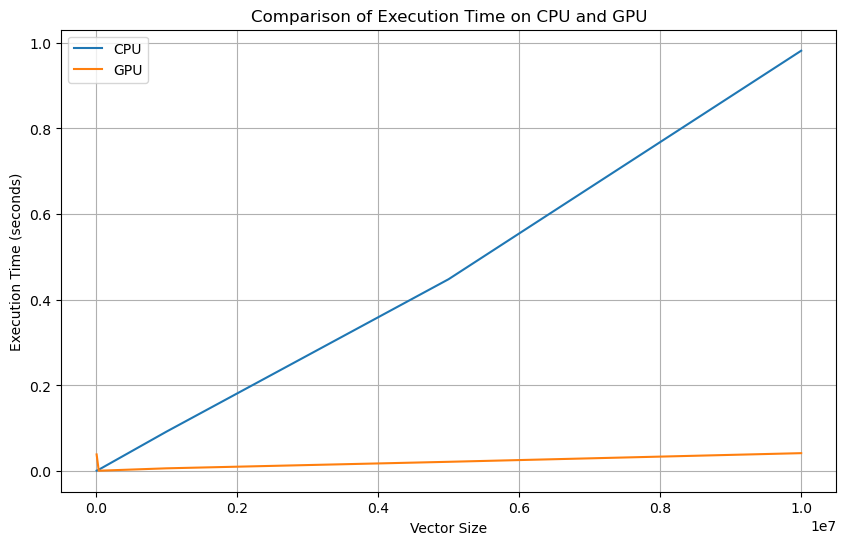

In [60]:
def plot_results(results):
    sizes = [result['Vector size'] for result in results]
    times_cpu = [result['CPU time'] for result in results]
    times_gpu = [result['GPU time'] for result in results]

    # Построение графика
    plt.figure(figsize=(10, 6))
    plt.plot(sizes, times_cpu, label='CPU')
    plt.plot(sizes, times_gpu, label='GPU')
    plt.xlabel('Vector Size')
    plt.ylabel('Execution Time (seconds)')
    plt.title('Comparison of Execution Time on CPU and GPU')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_results(results)

In [30]:
# По результатам суммирования видно, что итотговая сумма, вычисленная на GPU - сходится с вычесленной на CPU